In [1]:
import os
from torch.utils.data import DataLoader
from dataloader_e2e import create_dataset_12
import matplotlib.pyplot as plt
from PIL import ImageOps
import torchvision
import numpy as np
import cv2

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import *


device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)
path = os.getcwd()
path = '/root/notebooks/sample/dataset/ECG100_224_new/'
train_dataloader,test_dataloader,label_lead, labels=create_dataset_12(path,1,None)

/python/build/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:1
Classification lab : {'Lateral': 0, 'Posterior': 1, 'Anterior': 2, 'Inferior': 3, 'Normal': 4}
Number of datas 368
torch.Size([12, 368, 3, 112, 224])
368
368


In [2]:
# モデルクラス 
## バックボーンCNN
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # 畳み込み層や全結合層などを定義する
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.faltten = nn.Flatten()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.gap(x)
        x = self.faltten(x)
        #x = x.view(-1, 16 * 56 * 112)  
        return x

## Attentionヘッド
class Attention_Input(nn.Module):
    def __init__(self):
        super(Attention_Input, self).__init__()
        self.cls_token = nn.Parameter(torch.randn(32))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x と cls_token を連結
        z_0 = torch.cat([self.cls_token.unsqueeze(0), x], dim=0)
        return z_0
# AttentionInputをnn.Moduleに変更
class AttentionInput(nn.Module):
    def __init__(self):
        super(AttentionInput, self).__init__()
        self.attention_input = Attention_Input()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # AttentionInputのforwardメソッドを呼び出す
        output = self.attention_input(x)
        return output

## Vision Transformer encoder (スキップ接続なし)
class VitEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout):
        super(VitEncoder, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        # Layer Norm
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)
        # MultiheadAttentionのためにクエリ、キー、バリューの変換を行う層を定義
        self.query_transform = nn.Linear(embed_dim, embed_dim)
        self.key_transform = nn.Linear(embed_dim, embed_dim)
        self.value_transform = nn.Linear(embed_dim, embed_dim)
        # MultiheadAttentionレイヤー
        self.multihead_attention = nn.MultiheadAttention(embed_dim, num_heads)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        out = self.ln1(x)

        # クエリ、キー、バリューの変換
        query = self.query_transform(out)
        key = self.key_transform(out)
        value = self.value_transform(out)

        # MultiheadAttentionの適用
        attention_output, _ = self.multihead_attention(query, key, value)
        
        out = attention_output  
        out = self.mlp(self.ln2(out))  
        return out

# # Attentionの出力からCLSトークンを抽出   
class Take_cls(nn.Module):
    def forward(self, x):
        return x[0, :].reshape(1, 32)



In [3]:
# 特徴抽出器とAttentionレイヤーのインスタンスを作成
feature_extractor = CNNModel().to(device)
att_input = AttentionInput().to(device)
vit_encoder = VitEncoder(32, 4, 0.2).to(device)
take_cls = Take_cls().to(device)

CNN_diagnosis = nn.Sequential(
    feature_extractor,
    att_input,
    vit_encoder,
    vit_encoder,
    take_cls,
    nn.Linear(32, 5)
)

CNN_diagnosis.to(device)

print(CNN_diagnosis)

#出力テスト
input_shape = (12, 3, 112, 224)
test_input = torch.randn(input_shape).to(device)

test_output = CNN_diagnosis(test_input).to(torch.float64)
feature_output = feature_extractor(test_input).to(torch.float64)
print(test_output.shape)
print(feature_output.shape)

Sequential(
  (0): CNNModel(
    (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (gap): AdaptiveAvgPool2d(output_size=1)
    (faltten): Flatten(start_dim=1, end_dim=-1)
  )
  (1): AttentionInput(
    (attention_input): Attention_Input()
  )
  (2): VitEncoder(
    (ln1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (ln2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (query_transform): Linear(in_features=32, out_features=32, bias=True)
    (key_transform): Linear(in_features=32, out_features=32, bias=True)
    (value_transform): Linear(in_features=32, out_features=32, bias=True)
    (multihead_attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_fe

In [4]:
## 診断

# 損失関数
criterion = nn.CrossEntropyLoss()


# 最適化アルゴリズム
optimizer = optim.Adam(CNN_diagnosis.parameters(), lr=0.0001)
bestscore_dx = 1000.0
loss_list_dx,loss_list_test_dx = [], []
f1s_dx, f1s_test_dx = [],[]
acc_dx, acc_test_dx = [], []

num_epochs = 100

# モデル訓練　5クラス分類

for epoch in range(num_epochs):
    CNN_diagnosis.train()
    running_loss_dx = 0.0
    preds_dx, label_dx = [], []
    running_loss_dx, running_loss_test_dx = 0.0, 0.0
    preds_test_dx,label_test_dx = [], []

    for ecg_image, labels, label_lead, patients, num_leads in train_dataloader:
        image = ecg_image.reshape(-1, 3, 112, 224).to(device)
        labels = labels.reshape(-1).to(device)  # ラベルを1次元に変形
        labels = labels.to(torch.long)  # CrossEntropyLossではクラスのインデックスはlong型である必要がある

        optimizer.zero_grad()  # 勾配を初期化

        outputs = CNN_diagnosis(image).to(torch.float64)  # モデルの出力を計算

        prob, pred = torch.max(outputs, 1)
        preds_dx.extend(pred.tolist())
        label_dx.extend(labels.tolist())

        loss = criterion(outputs, labels)  # 損失を計算（CrossEntropyLossの引数は予測とラベル）
        loss.backward()  # 勾配を計算
        optimizer.step()  # パラメータを更新

        running_loss_dx += loss.item()

    for ecg_image,labels,label_lead,patients,num_leads in test_dataloader:
        image =ecg_image.reshape(-1,3,112,224).to(device)
        labels = labels.reshape(-1).to(device)

        outputs = CNN_diagnosis(image)  # モデルの出力を計算
        outputs = outputs.to(torch.float64)
        prob, pred=torch.max(outputs,1)
        preds_test_dx.extend(pred.tolist())
        label_test_dx.extend(labels.tolist())
        
        #print(outputs)
        loss = criterion(outputs, labels)  # 損失を計算

        running_loss_test_dx += loss.item()
    
    score_dx = running_loss_test_dx/len(test_dataloader)
    
    loss_list_dx.append(running_loss_dx/len(train_dataloader))
    loss_list_test_dx.append(running_loss_test_dx/len(test_dataloader))
    f1_dx = f1_score(preds_dx,label_dx,average='macro')
    f1_test_dx = f1_score(preds_test_dx,label_test_dx,average='macro')
    f1s_dx.append(f1_dx)
    f1s_test_dx.append(f1_test_dx)
    accuracy_dx = accuracy_score(preds_dx,label_dx)
    accuracy_test_dx = accuracy_score(preds_test_dx,label_test_dx)
    acc_dx.append(accuracy_dx)
    acc_test_dx.append(accuracy_test_dx)

    if score_dx < bestscore_dx:
        bestscore_dx = score_dx
        torch.save(CNN_diagnosis.state_dict(), '/root/notebooks/sample/models/bestmodel_dx_rand.pth')
        print('best score_dx!!')
        bestf1_dx = f1_test_dx
        bestacc_dx = accuracy_test_dx

    # 1エポック終了時の損失を表示
    print(f"Epoch [{epoch+1}/{num_epochs}] Train-Loss: {running_loss_dx/len(train_dataloader)} Test-Loss: {running_loss_test_dx/len(train_dataloader)} Train-f1: {f1_dx} Test-f1: {f1_test_dx} Train-acc: {accuracy_dx} Test-acc: {accuracy_test_dx}")

best score_dx!!
Epoch [1/100] Train-Loss: 1.3966747506767565 Test-Loss: 0.33634735864682536 Train-f1: 0.1252336448598131 Test-f1: 0.12592592592592594 Train-acc: 0.4557823129251701 Test-acc: 0.4594594594594595
Epoch [2/100] Train-Loss: 1.3282409383992646 Test-Loss: 0.3376689365080841 Train-f1: 0.12680652680652682 Test-f1: 0.14830188679245282 Train-acc: 0.46258503401360546 Test-acc: 0.47297297297297297
best score_dx!!
Epoch [3/100] Train-Loss: 1.3124237171215933 Test-Loss: 0.3325344068420935 Train-f1: 0.12582159624413145 Test-f1: 0.12592592592592594 Train-acc: 0.4557823129251701 Test-acc: 0.4594594594594595
best score_dx!!
Epoch [4/100] Train-Loss: 1.296336083772157 Test-Loss: 0.326066511163009 Train-f1: 0.12680652680652682 Test-f1: 0.12592592592592594 Train-acc: 0.46258503401360546 Test-acc: 0.4594594594594595
Epoch [5/100] Train-Loss: 1.284161192399285 Test-Loss: 0.32906028582459335 Train-f1: 0.14881251714793642 Test-f1: 0.1419047619047619 Train-acc: 0.46938775510204084 Test-acc: 0.445

In [5]:
# モデル評価 ５クラス診断
pred_dx,label_dx = [],[]
CNN_diagnosis.load_state_dict(torch.load('/root/notebooks/sample/models/bestmodel_dx_rand.pth'))
CNN_diagnosis.eval()

for ecg_image,labels,label_lead,patients,num_leads in test_dataloader:
    image =ecg_image.reshape(-1,3,112,224).to(device)
    labels = labels.reshape(-1).to(device)
    label_dx.extend(labels.tolist())
    outputs = CNN_diagnosis(image)  # モデルの出力を計算
    prob_dx, preds_dx=torch.max(outputs,1)
    pred_dx.extend(preds_dx.tolist())
    f1_test_dx = f1_score(preds_dx.tolist(),labels.tolist(),average='macro')
    accuracy_test_dx = accuracy_score(preds_test_dx,label_test_dx)
    loss = criterion(outputs, labels)  # 損失を計算

    running_loss_test_dx += loss.item()

In [6]:
print(bestf1_dx)
print(bestacc_dx)

0.12592592592592594
0.4594594594594595


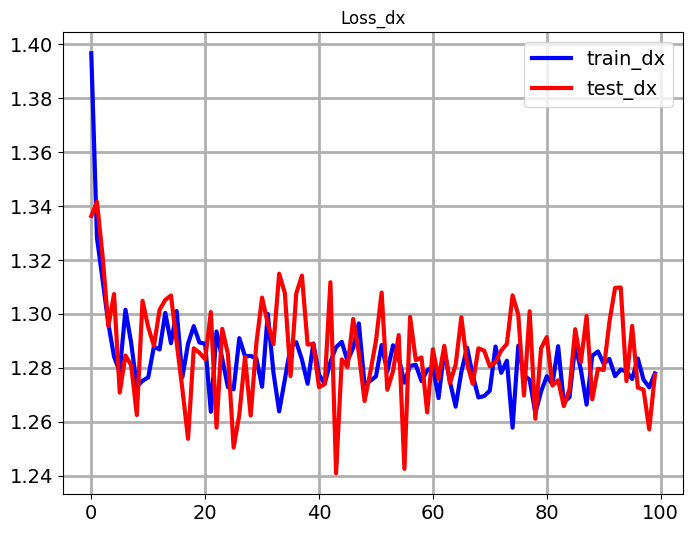

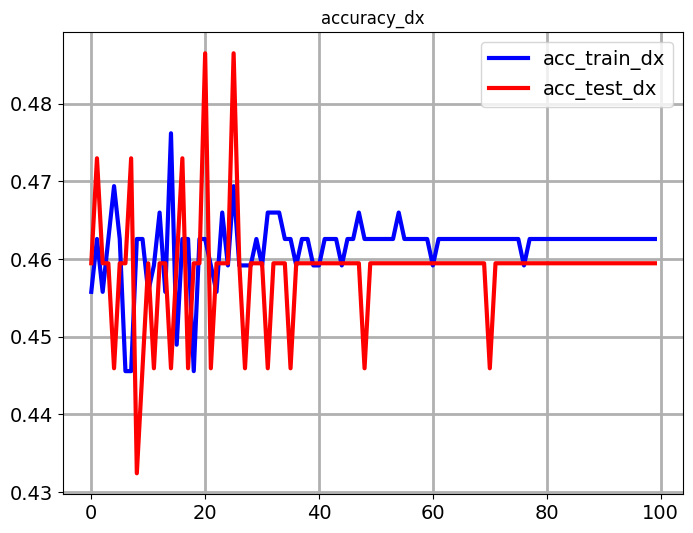

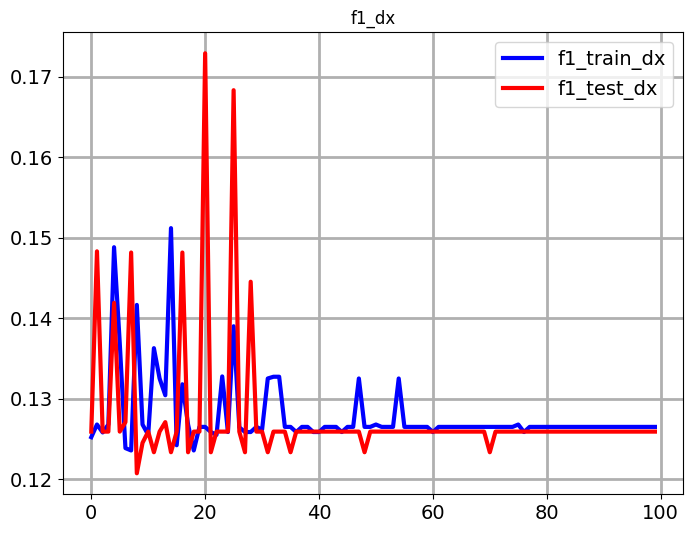

In [7]:
# 学習曲線 (損失関数) 診断モデル
plt.figure(figsize=(8,6))
plt.plot(loss_list_dx,label='train_dx', lw=3, c='b')
plt.plot(loss_list_test_dx,label='test_dx', lw=3, c='r')
plt.title('Loss_dx')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

# 学習曲線 (accuracy)
plt.figure(figsize=(8,6))
plt.plot(acc_dx,label='acc_train_dx', lw=3, c='b')
plt.plot(acc_test_dx,label='acc_test_dx', lw=3, c='r')
plt.title('accuracy_dx')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

# 学習曲線 (f1)
plt.figure(figsize=(8,6))
plt.plot(f1s_dx,label='f1_train_dx', lw=3, c='b')
plt.plot(f1s_test_dx,label='f1_test_dx', lw=3, c='r')
plt.title('f1_dx')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

In [8]:
# Confusion matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
           """
           This function prints and plots the confusion matrix.
           Normalization can be applied by setting `normalize=True`.
           """
           if normalize:
               cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
               print("Normalized confusion matrix")
           else:
               print('Confusion matrix, without normalization')
           print(cm)
           plt.imshow(cm, interpolation='nearest', cmap=cmap)
           plt.title(title)
           plt.colorbar()
           tick_marks = np.arange(len(classes))
           plt.xticks(tick_marks, classes, rotation=45)
           plt.yticks(tick_marks, classes)
           fmt = '.2f' if normalize else 'd'
           thresh = cm.max() / 2.
           for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
               plt.text(j, i, format(cm[i, j], fmt),
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")
           plt.tight_layout()
           plt.ylabel('True label')
           plt.xlabel('Predicted label')
           #plt.savefig(output_file)



Confusion matrix, without normalization
[[ 0  0  0  0  1]
 [ 0  0  0  0  5]
 [ 0  0  0  0 18]
 [ 0  0  0  0 16]
 [ 0  0  0  0 34]]


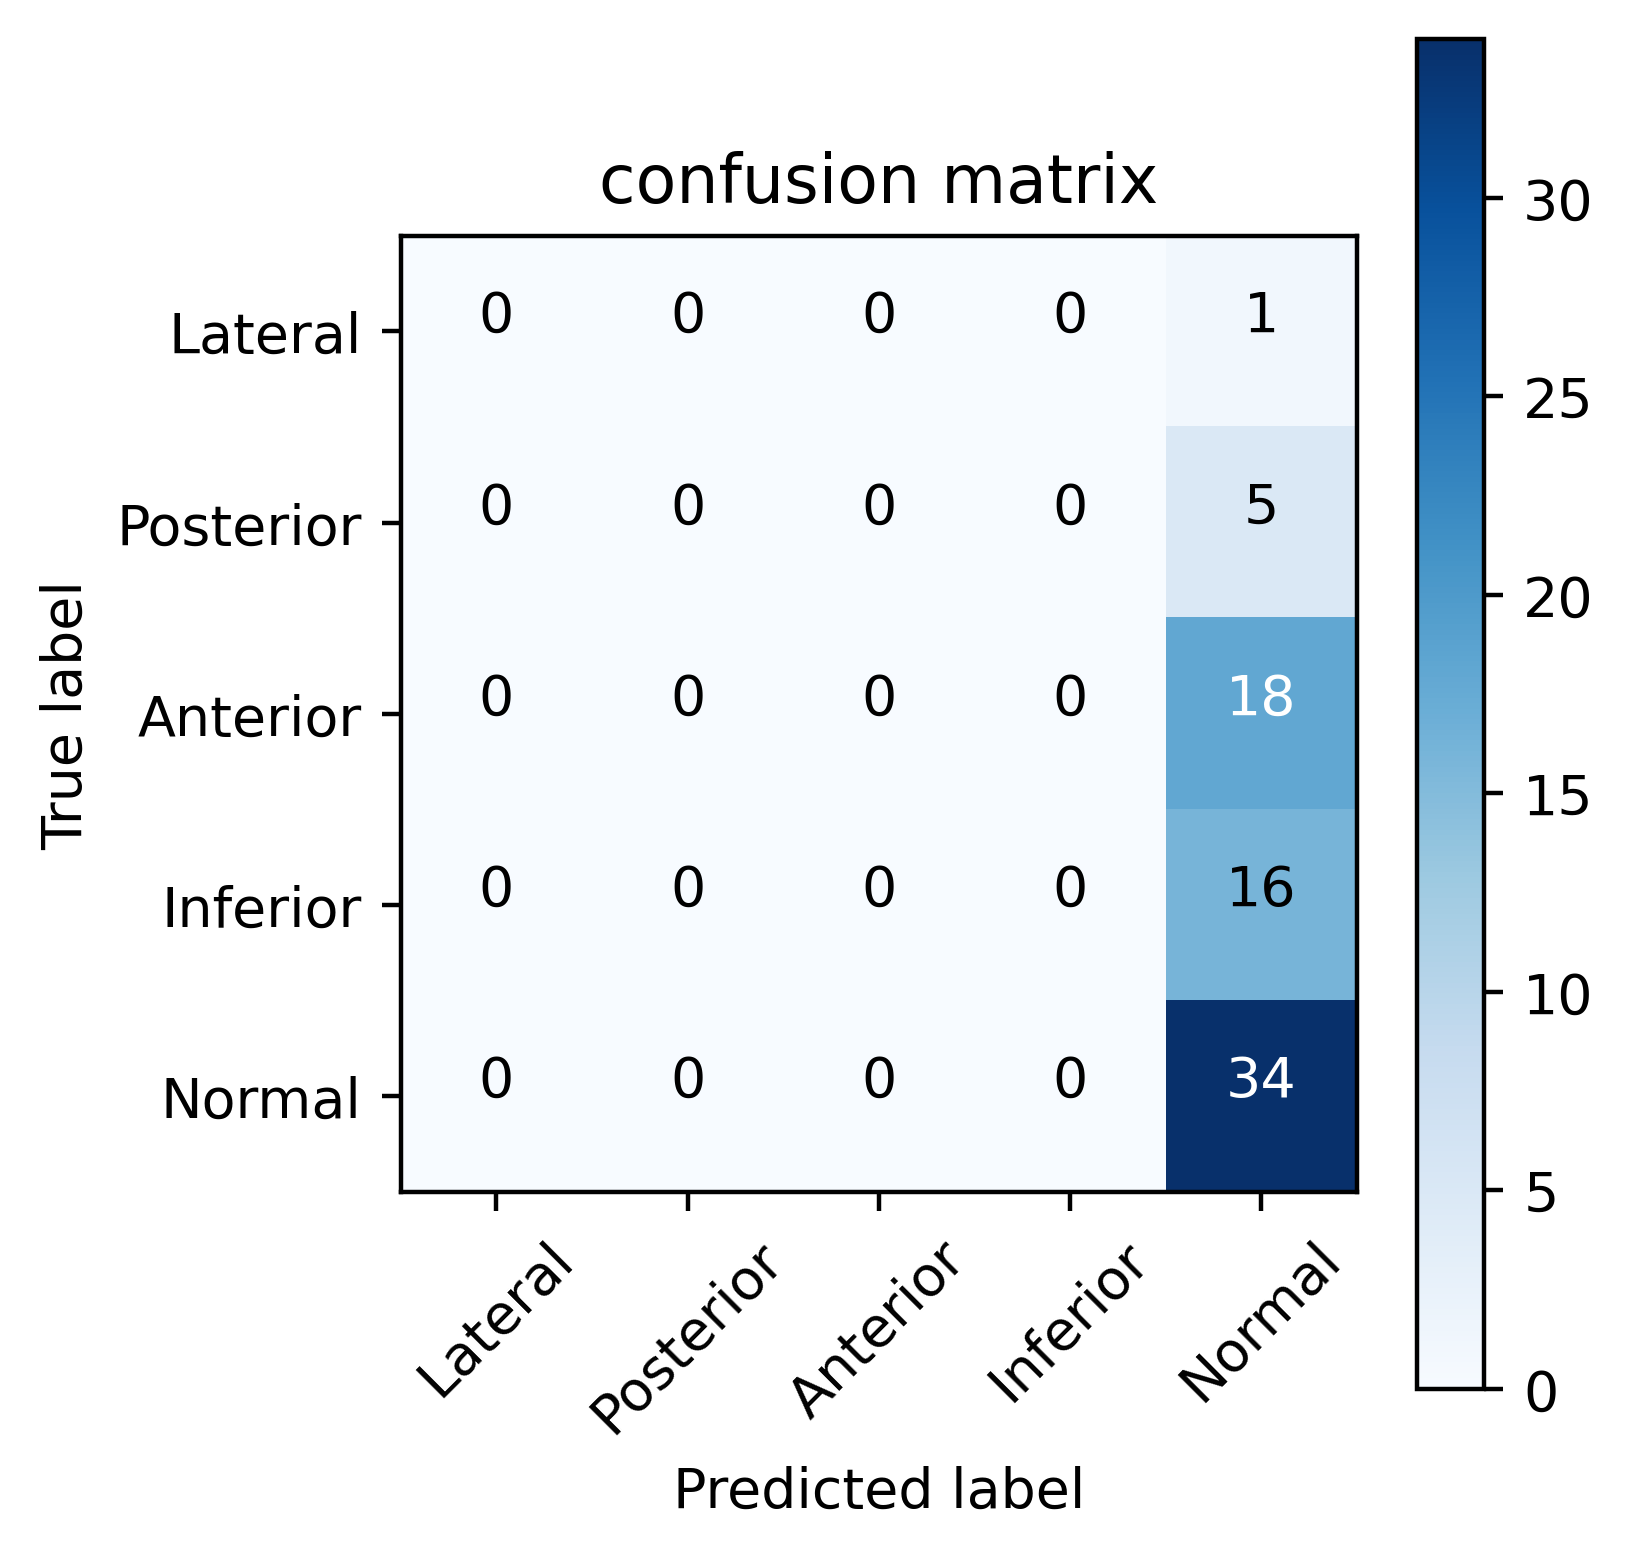

: 

In [9]:
labels_dx=[0,1,2,3,4]
label2_dx=['Lateral','Posterior', 'Anterior', 'Inferior', 'Normal']
cnf_matrix=confusion_matrix(label_dx,pred_dx,labels=labels_dx)
title="confusion matrix"
plt.figure(figsize=(4,4),dpi=400)
plot_confusion_matrix(cnf_matrix, classes=label2_dx,title=title)
plt.show()